In [1]:
from sklearn import *
import sklearn
import pandas as pd
import numpy as np
import xgboost as xgb
import nltk, re, math, collections

/home/zhao/anaconda2/lib/python2.7/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/home/zhao/anaconda2/lib/python2.7/site-packages/sklearn/grid_search.py:42: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)
/home/zhao/anaconda2/lib/python2.7/site-packages/sklearn/learning_curve.py:22: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the functions are moved. This module will be removed in 0.20
  Dep

In [23]:
train = pd.read_csv('./data/train.csv')
test = pd.read_csv('./data/test.csv')

In [3]:
uniqtrain = pd.read_csv('./uniqtrain.csv')
uniqtest = pd.read_csv('./uniqtest.csv')
del uniqtrain['RealClass']
train = pd.concat([train,uniqtrain],axis=1)
test = pd.concat([test,uniqtest],axis=1)

In [24]:
test.ID = pd.to_numeric(test.ID, errors='coerce')
test['ID'] = test['ID'].astype(int)
pid = test['ID'].values

In [25]:
df_all = pd.concat((train, test), axis=0, ignore_index=True)

In [6]:
df_all.head()

,Gene,ID,Text,Variation,Gene_Share,Variation_Share,Gene_0,Variation0,Gene_1,Variation1,...,GV_p61BRAF,class1,class2,class3,class4,class5,class6,class7,class8,class9
0,FAM58A,0.0,Cyclin-dependent kinases (CDKs) regulate a var...,Truncating Mutations,1.0,1.0,5.0,24.0,3.0,40.0,...,0.0,0.535144,0.065495,0.000000,0.068690,0.001597,0.017572,0.308307,0.001597,0.001597
1,CBL,1.0,Abstract Background Non-small cell lung canc...,W802*,1.0,1.0,2.0,26.0,4.0,9.0,...,0.0,0.008000,0.456000,0.000000,0.000000,0.000000,0.456000,0.080000,0.000000,0.000000
2,CBL,2.0,Abstract Background Non-small cell lung canc...,Q249E,1.0,1.0,2.0,21.0,4.0,3.0,...,0.0,0.008000,0.456000,0.000000,0.000000,0.000000,0.456000,0.080000,0.000000,0.000000
3,CBL,3.0,Recent evidence has demonstrated that acquired...,N454D,1.0,1.0,2.0,18.0,4.0,5.0,...,0.0,0.185714,0.007143,0.389286,0.389286,0.000000,0.003571,0.025000,0.000000,0.000000
4,CBL,4.0,Oncogenic mutations in the monomeric Casitas B...,L399V,1.0,1.0,2.0,16.0,4.0,4.0,...,0.0,0.000000,0.000000,0.000000,0.333333,0.333333,0.333333,0.000000,0.000000,0.000000


In [27]:
import re

def textClean(text):
    text = re.sub(r"[^A-Za-z0-9^,!.\/'+-=]", " ", text)
    text = text.lower().split()
    stops = {'study', 'table', 'method', 'conclusion', 'case', 'data', 'syndrome', 'analyze', 
                 'author', 'show', 'control', 'expression', 'supplementary', 'result', 'figure','fig', 
                  'level', 'deletion', 'mm', 'state', 'effect', 'stability', 'activity','change','structure', 
                  'line', 'loss', 'expression', 'et', 'al'}
    ## I ketp getting errors on importing the stopwords and I have no clue why
    #stops = set(stopwords.words("English"))
    text = [w for w in text if not w in stops]    
    text = " ".join(text)
    text = text.replace("."," ").replace(","," ")
    return(text)
df_all['Text'] = df_all['Text'].apply(textClean)

/home/zhao/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:1: FutureWarning: currently extract(expand=None) means expand=False (return Index/Series/DataFrame) but in a future version of pandas this will be changed to expand=True (return DataFrame)
  if __name__ == '__main__':


In [28]:
train = df_all.iloc[:len(train)]
test = df_all.iloc[len(train):]

In [29]:
class cust_regression_vals(sklearn.base.BaseEstimator, sklearn.base.TransformerMixin):
    def fit(self, x, y=None):
        return self
    def transform(self, x):
        x = x.drop(['Gene', 'Variation','ID','Text'],axis=1).values
        return x

class cust_txt_col(sklearn.base.BaseEstimator, sklearn.base.TransformerMixin):
    def __init__(self, key):
        self.key = key
    def fit(self, x, y=None):
        return self
    def transform(self, x):
        return x[self.key].apply(str)
    
fp = pipeline.Pipeline([
    ('union', pipeline.FeatureUnion(
        n_jobs = -1,
        transformer_list = [
            ('standard', cust_regression_vals()),
            ('pi1', pipeline.Pipeline([('Gene', cust_txt_col('Gene')), ('count_Gene', feature_extraction.text.CountVectorizer(analyzer=u'char', ngram_range=(1, 8))), ('tsvd1', decomposition.TruncatedSVD(n_components=20, n_iter=25, random_state=12))])),
            ('pi2', pipeline.Pipeline([('Variation', cust_txt_col('Variation')), ('count_Variation', feature_extraction.text.CountVectorizer(analyzer=u'char', ngram_range=(1, 8))), ('tsvd2', decomposition.TruncatedSVD(n_components=20, n_iter=25, random_state=12))])),
            #commented for Kaggle Limits
            ('pi3', pipeline.Pipeline([('Text', cust_txt_col('Text')), ('tfidf_Text', feature_extraction.text.TfidfVectorizer(ngram_range=(1, 2))), ('tsvd3', decomposition.TruncatedSVD(n_components=50, n_iter=25, random_state=12))]))
        ])
    )])

train = fp.fit_transform(train); print(train.shape)
test = fp.transform(test); print(test.shape)

(3689, 2986)
(986, 2986)


In [30]:
temp = pd.read_csv('./data/stage_2_train.csv')
y = temp['Class'].values

xgboost LB native 0.28+

In [31]:
y = y - 1 #fix for zero bound array

denom = 0
fold = 5 
for i in range(fold):
    params = {
        'eta': 0.03333,
        'max_depth': 4,
        'objective': 'multi:softprob',
        'eval_metric': 'mlogloss',
        'num_class': 9,
        'seed': i,
        'silent': True
    }
    x1, x2, y1, y2 = model_selection.train_test_split(train, y, test_size=0.18, random_state=i)
    watchlist = [(xgb.DMatrix(x1, y1), 'train'), (xgb.DMatrix(x2, y2), 'valid')]
    model = xgb.train(params, xgb.DMatrix(x1, y1), 1000,  watchlist, verbose_eval=50, early_stopping_rounds=100)
    score1 = metrics.log_loss(y2, model.predict(xgb.DMatrix(x2), ntree_limit=model.best_ntree_limit), labels = list(range(9)))
    print(score1)
    if score1 < 0.86:
        if denom != 0:
            pred = model.predict(xgb.DMatrix(test), ntree_limit=model.best_ntree_limit+80)
            preds += pred
        else:
            pred = model.predict(xgb.DMatrix(test), ntree_limit=model.best_ntree_limit+80)
            preds = pred.copy()
        denom += 1
        submission = pd.DataFrame(pred, columns=['class'+str(c+1) for c in range(9)])
        submission['ID'] = pid
        submission.to_csv('submission_xgb_fold_'  + str(i) + '.csv', index=False)
preds /= denom
submission_xgb = pd.DataFrame(preds, columns=['class'+str(c+1) for c in range(9)])
submission_xgb['ID'] = pid
#submission.to_csv('submission_xgb.csv', index=False)


[0]	train-mlogloss:2.13994	valid-mlogloss:2.14694
Multiple eval metrics have been passed: 'valid-mlogloss' will be used for early stopping.

Will train until valid-mlogloss hasn't improved in 100 rounds.
[50]	train-mlogloss:1.10105	valid-mlogloss:1.25403
[100]	train-mlogloss:0.816886	valid-mlogloss:1.04861
[150]	train-mlogloss:0.669863	valid-mlogloss:0.971352
[200]	train-mlogloss:0.573596	valid-mlogloss:0.938057
[250]	train-mlogloss:0.500224	valid-mlogloss:0.916575
[300]	train-mlogloss:0.440726	valid-mlogloss:0.902317
[350]	train-mlogloss:0.39294	valid-mlogloss:0.89561
[400]	train-mlogloss:0.353967	valid-mlogloss:0.894827
[450]	train-mlogloss:0.318556	valid-mlogloss:0.893431
[500]	train-mlogloss:0.288523	valid-mlogloss:0.893569
[550]	train-mlogloss:0.259752	valid-mlogloss:0.893714
Stopping. Best iteration:
[482]	train-mlogloss:0.298601	valid-mlogloss:0.892791

0.892790685163
[0]	train-mlogloss:2.14067	valid-mlogloss:2.14257
Multiple eval metrics have been passed: 'valid-mlogloss' will 

## lgb

In [32]:
import lightgbm as lgb

#y = y - 1 #fix for zero bound array
denom = 0
fold = 5 
for i in range(fold):
    parms = {'task': 'train',
        'boosting_type': 'gbdt',
        'objective': 'multiclass',
        'num_class': 9,
        'metric': {'multi_logloss'},
        'learning_rate': 0.03, 
        'max_depth': 5,
        'num_iterations': 400, 
        'num_leaves': 95, 
        'min_data_in_leaf': 60, 
        'lambda_l1': 1.0,
        'feature_fraction': 0.8, 
        'bagging_fraction': 0.8, 
        'bagging_freq': 5
    }
    x1, x2, y1, y2 = model_selection.train_test_split(train, y, test_size=0.18, random_state=i)
    d_train = lgb.Dataset(x1, label=y1)
    d_val = lgb.Dataset(x2, label=y2)
    model = lgb.train(parms, train_set=d_train, num_boost_round=1000,
               valid_sets=[d_val], valid_names=['dval'], verbose_eval=50,
               early_stopping_rounds=100)
    score1 = metrics.log_loss(y2, model.predict(x2), labels = list(range(9)))
    print(score1)
    if score1 < 0.85:
        if denom != 0:
            pred = model.predict(test)
            preds += pred
        else:
            pred = model.predict(test)
            preds = pred.copy()
        denom += 1
        submission = pd.DataFrame(pred, columns=['class'+str(c+1) for c in range(9)])
        submission['ID'] = pid
        submission.to_csv('submission_lgb_fold_'  + str(i) + '.csv', index=False)
preds /= denom
submission_lgb = pd.DataFrame(preds, columns=['class'+str(c+1) for c in range(9)])
submission_lgb['ID'] = pid
#submission.to_csv('submission_lgb.csv', index=False)


Training until validation scores don't improve for 100 rounds.
[50]	dval's multi_logloss: 1.3199
[100]	dval's multi_logloss: 1.08954
[150]	dval's multi_logloss: 0.987452
[200]	dval's multi_logloss: 0.938976
[250]	dval's multi_logloss: 0.910078
[300]	dval's multi_logloss: 0.895935
[350]	dval's multi_logloss: 0.886784
[400]	dval's multi_logloss: 0.882275
0.882275347726
Training until validation scores don't improve for 100 rounds.
[50]	dval's multi_logloss: 1.29497
[100]	dval's multi_logloss: 1.05651
[150]	dval's multi_logloss: 0.953013
[200]	dval's multi_logloss: 0.89771
[250]	dval's multi_logloss: 0.86566
[300]	dval's multi_logloss: 0.849422
[350]	dval's multi_logloss: 0.836207
[400]	dval's multi_logloss: 0.826032
0.826032144864
Training until validation scores don't improve for 100 rounds.
[50]	dval's multi_logloss: 1.29664
[100]	dval's multi_logloss: 1.05903
[150]	dval's multi_logloss: 0.950677
[200]	dval's multi_logloss: 0.895297
[250]	dval's multi_logloss: 0.862055
[300]	dval's mul

# ...

In [40]:
submission = 0.4*submission_lgb+0.6*submission_xgb

In [41]:
submission['ID'] = submission['ID'].astype(int)

In [42]:
sub = pd.read_csv('./data/stage2_sample_submission.csv')
stage1_test = pd.read_csv('./data/test_variants')
stage2_test = pd.read_csv('./data/stage2_test_variants.csv')
stage1_solution = pd.read_csv('./data/stage1_solution_filtered.csv')

stage1_solution = stage1_solution.merge(stage1_test, how = 'left', on = 'ID')

leak = stage2_test.merge(
        stage1_solution.drop('ID', axis = 1), 
        how = 'left', 
        on = ['Gene', 'Variation'])

In [43]:
del leak['Gene']
del leak['Variation']
leak = leak.dropna()
ids = leak['ID']

In [44]:
submission = submission.drop(ids-1)
submission = pd.concat([submission,leak])
submission = submission.sort_index(by='ID')

/home/zhao/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:3: FutureWarning: by argument to sort_index is deprecated, pls use .sort_values(by=...)
  app.launch_new_instance()


In [38]:
submission.to_csv('submission_xgb.csv', index=False)

In [45]:
submission

,ID,class1,class2,class3,class4,class5,class6,class7,class8,class9
0,1,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,2,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,3,0.103781,0.129646,0.007151,0.474888,0.018364,0.024839,0.237849,0.001355,0.002126
3,4,0.351872,0.112307,0.010134,0.205226,0.016439,0.052986,0.217455,0.002642,0.030938
4,5,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000
5,6,0.187053,0.061884,0.009771,0.615321,0.021621,0.013540,0.082331,0.001377,0.007102
6,7,0.019883,0.110874,0.019315,0.042962,0.027170,0.019634,0.755851,0.002037,0.002273
7,8,0.235430,0.098343,0.010058,0.345682,0.031706,0.134878,0.135309,0.001352,0.007241
8,9,0.252447,0.035283,0.005841,0.549314,0.012076,0.016277,0.119283,0.001580,0.007899
9,10,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000


# .....

In [18]:
submission

,class1,class2,class3,class4,class5,class6,class7,class8,class9,ID
0,0.000496,0.000231,0.000141,0.997990,0.000404,0.000370,0.000244,0.000061,0.000063,1
1,0.998956,0.000271,0.000077,0.000187,0.000084,0.000131,0.000219,0.000037,0.000039,2
2,0.002627,0.060485,0.000634,0.002809,0.002217,0.000601,0.929700,0.000582,0.000345,3
3,0.001041,0.000206,0.000233,0.000437,0.000433,0.000421,0.996956,0.000076,0.000197,4
4,0.000369,0.004722,0.000224,0.000260,0.000307,0.000162,0.993702,0.000168,0.000085,5
5,0.977945,0.002690,0.001958,0.004232,0.005331,0.001842,0.004698,0.000570,0.000734,6
6,0.000407,0.000181,0.000137,0.000396,0.000440,0.000126,0.998182,0.000058,0.000074,7
7,0.007971,0.006611,0.003825,0.962057,0.007490,0.004025,0.005253,0.001425,0.001342,8
8,0.179698,0.001145,0.000581,0.814992,0.001081,0.000696,0.001300,0.000253,0.000254,9
9,0.005153,0.004881,0.087708,0.001711,0.042165,0.006122,0.851175,0.000659,0.000427,10


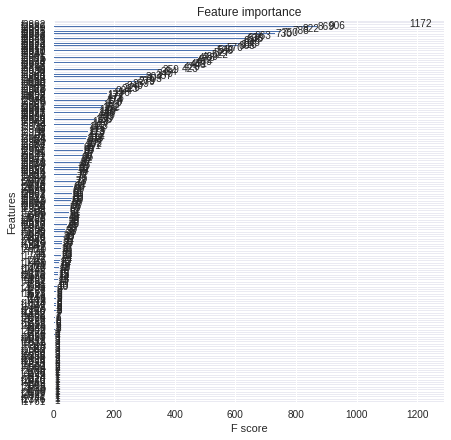

In [19]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

plt.rcParams['figure.figsize'] = (7.0, 7.0)
xgb.plot_importance(booster=model); plt.show()